In [2]:
import numpy as np
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, Dropout, Convolution2D, GlobalAveragePooling2D
from keras.models import Sequential
import tensorflow as tf
import tensorflow.keras.applications.mobilenet
import os
import PIL
import cv2
import keras
import matplotlib.pyplot as plt
from keras import layers
from keras import Model
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau


In [3]:
IMG_SAVE_PATH_Test = 'preprocess/test'

# Get a list of folder names in the directory
folders = [name for name in os.listdir(IMG_SAVE_PATH_Test) if os.path.isdir(os.path.join(IMG_SAVE_PATH_Test, name))]

# Create a dictionary with index as key and folder name as value
folders_dict = {folder: index for index, folder in enumerate(folders)}
folders_dict

{'fake': 0, 'real': 1}

In [4]:
IMG_SAVE_PATH_Train = 'preprocess/train'
IMG_SAVE_PATH_Test = 'preprocess/test'
Str_to_Int =folders_dict



NUM_CLASSES = 2
def str_to_Int_mapper(val):
    return Str_to_Int[val]



def preprocess(IMG_SAVE_PATH):
    dataset = []
    for directory in os.listdir(IMG_SAVE_PATH):
        path = os.path.join(IMG_SAVE_PATH, directory)
        for image in os.listdir(path):
            new_path = os.path.join(path, image)
            try:
                imgpath=PIL.Image.open(new_path)
                imgpath=imgpath.convert('RGB')
                img = np.asarray(imgpath)
                img = cv2.resize(img, (224,224))
                img=img/255.
                dataset.append([img, directory])
            except FileNotFoundError:
                print('Image file not found. Skipping...')
    return dataset


In [5]:
traindata=preprocess(IMG_SAVE_PATH_Train)

In [6]:
testdata=preprocess(IMG_SAVE_PATH_Test)

In [7]:
xtrain, labelstrain = zip(*traindata)
xtest, labelstest = zip(*testdata)

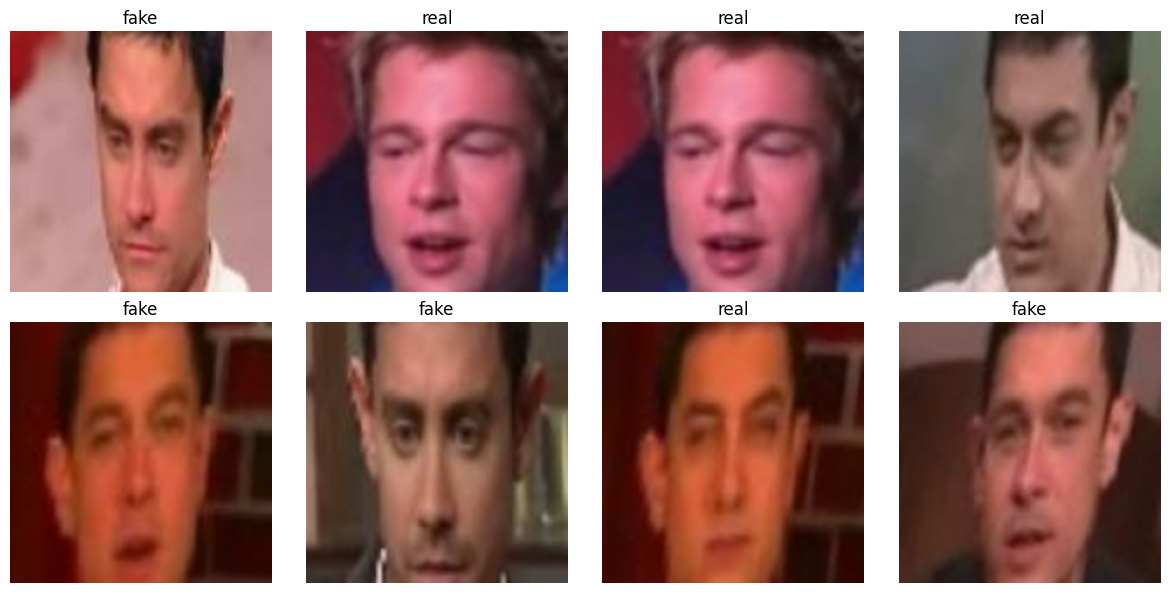

In [8]:

import matplotlib.pyplot as plt
import random

# Randomly select 8 indices from the dataset
indices = random.sample(range(len(xtrain)), 8)

# Set up the plot grid
plt.figure(figsize=(12, 6))

# Loop through the selected indices
for i, idx in enumerate(indices):
    plt.subplot(2, 4, i + 1)  # 2 rows, 4 columns
    plt.imshow(xtrain[idx])  # Assuming data[idx] is an image
    plt.title(labelstrain[idx])
    plt.axis('off')

# Display the plot
plt.tight_layout()
plt.show()


In [9]:
temp = list(map(str_to_Int_mapper, labelstrain))
ytrain = tensorflow.keras.utils.to_categorical(temp)
temp1 = list(map(str_to_Int_mapper, labelstest))
ytest = tensorflow.keras.utils.to_categorical(temp1)

In [10]:
xtrain=np.array(xtrain)
xtest=np.array(xtest)
ytrain=np.array(ytrain)
ytest=np.array(ytest)

In [11]:
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape,

((1050, 224, 224, 3), (291, 224, 224, 3), (1050, 2), (291, 2))

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,GRU, Activation, BatchNormalization, GlobalAveragePooling2D, Dropout, Concatenate, Input
from tensorflow.keras.models import Model

# Base model (MobileNetV2) definition
def create_combined_model(num_classes=2,  mobile_input_shape=(224, 224, 3)):
    input_tensor = Input(shape=(224, 224, 3))
    
    # Pretrained MobileNetV2 (without top layers)
    base_model = tf.keras.applications.MobileNetV2(include_top=False,
                                                         weights='imagenet',
                                                         input_shape=mobile_input_shape)
    base_model.trainable = False  # Freeze MobileNetV2 layers
    
    # Flatten the output of the base model (MobileNetV2)
    inception_output = Flatten()(base_model.output)
    
    
    x = tf.keras.layers.Reshape((1, -1))(inception_output)
    x = GRU(128, return_sequences=True)(x)
    x = Flatten()(x)
    
    # Add dense layers after concatenation
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    
    # Output layer (adjust the output for the number of classes)
    output = Dense(num_classes, activation='softmax')(x)
    
    # Create the final model
    model = Model(inputs=[base_model.input], outputs=output)
    
    return model

# Instantiate the model
model = create_combined_model(num_classes=2)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the combined model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [13]:


epochs = 6

history = model.fit(xtrain, ytrain,
    epochs=epochs,
    validation_data=(xtest, ytest),
    verbose=1

)

Epoch 1/6
33/33 [==============================] - 15s 368ms/step - loss: 0.4870 - accuracy: 0.7229 - val_loss: 0.2703 - val_accuracy: 0.8866
Epoch 2/6
33/33 [==============================] - 11s 343ms/step - loss: 0.3081 - accuracy: 0.8638 - val_loss: 0.2024 - val_accuracy: 0.9141
Epoch 3/6
33/33 [==============================] - 11s 343ms/step - loss: 0.2188 - accuracy: 0.8981 - val_loss: 0.2078 - val_accuracy: 0.9244
Epoch 4/6
33/33 [==============================] - 11s 344ms/step - loss: 0.2021 - accuracy: 0.9210 - val_loss: 0.3308 - val_accuracy: 0.8763
Epoch 5/6
33/33 [==============================] - 11s 343ms/step - loss: 0.2564 - accuracy: 0.8933 - val_loss: 0.1718 - val_accuracy: 0.9210
Epoch 6/6
33/33 [==============================] - 11s 343ms/step - loss: 0.2316 - accuracy: 0.8943 - val_loss: 0.2955 - val_accuracy: 0.9003


In [20]:

history2 = model.fit(xtrain, ytrain,
    epochs=2,
    validation_data=(xtest, ytest),
    verbose=1

)

Epoch 1/2
33/33 [==============================] - 12s 352ms/step - loss: 0.1664 - accuracy: 0.9352 - val_loss: 0.1213 - val_accuracy: 0.9759
Epoch 2/2
33/33 [==============================] - 11s 347ms/step - loss: 0.1522 - accuracy: 0.9352 - val_loss: 0.2149 - val_accuracy: 0.9141


In [21]:
model.save('DeepFake.h5')

In [15]:
train_accuracy=[]
val_accuracy=[]
train_loss=[]
val_loss=[]

In [16]:
train_accuracy.extend(history.history['accuracy'])
val_accuracy.extend(history.history['val_accuracy'])
train_loss.extend(history.history['loss'])
val_loss.extend(history.history['val_loss'])


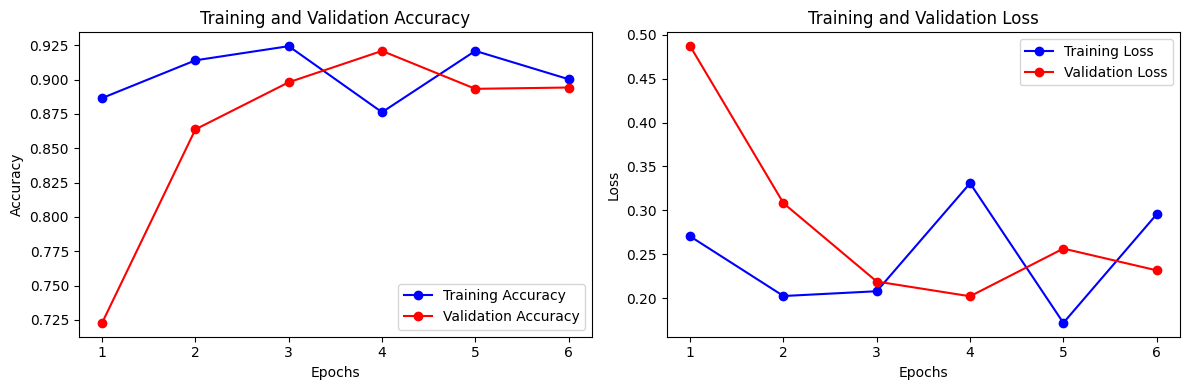

In [17]:

epochs = range(1, len(train_accuracy) + 1)
# Plotting Training and Validation Accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs,val_accuracy , 'bo-', label='Training Accuracy')
plt.plot(epochs, train_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs,val_loss , 'bo-', label='Training Loss')
plt.plot(epochs, train_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()